# Shopping Cart Abandonment Prediction
## Data Preparation
Data from https://www.kaggle.com/chadgostopp/recsys-challenge-2015

Place data files in `data` directory relative to this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
MAX_SESSION_LEN = 30

In [3]:
# Date parser
iso_date_parser = lambda x: pd.to_datetime(datetime.fromisoformat(x[:-1]))

# Read data
print('Reading click data...')
type_dict = {'ItemID': 'category', 'Category': 'category'}
df = pd.read_csv('data/yoochoose-clicks.dat',
                 header=None,
                 names=['SessionID', 'Timestamp', 'ItemID', 'Category'],
                 parse_dates=['Timestamp'],
                 dtype=type_dict,
                 date_parser=iso_date_parser)

print(f"Filtering sessions longer than {MAX_SESSION_LEN}...")
df = df.groupby('SessionID').filter(lambda x : len(x)<=MAX_SESSION_LEN).reset_index()

# Convert ItemID and Category to numeric categorical labels. Add 1 so we can reserve 0 for padding purposes.
print("Converting ItemID categories...")
df.ItemID = df.ItemID.cat.remove_unused_categories()
df.ItemID = df.ItemID.cat.codes + 1

print("Converting Category categories...")
df.Category = df.Category.cat.remove_unused_categories()
df.Category = df.Category.cat.codes + 1

# Bin timestamps in 4-hour intervals
print("Binning Timestamps...")
df.Timestamp = df.Timestamp.dt.to_period(freq='4h')
df.Timestamp = pd.Categorical(df.Timestamp)
df.Timestamp = df.Timestamp.cat.remove_unused_categories()
df.Timestamp = df.Timestamp.cat.codes + 1

df

Reading click data...
Filtering sessions longer than 30...
Converting ItemID categories...
Converting Category categories...
Binning Timestamps...


,index,SessionID,Timestamp,ItemID,Category
0,0,1,152,750,1
1,1,1,152,749,1
2,2,1,152,751,1
3,3,1,152,2624,1
4,4,2,155,5327,1
...,...,...,...,...,...
32007172,33003939,11299809,4255,9124,33
32007173,33003940,11299809,4255,20219,33
32007174,33003941,11299811,4241,50192,33
32007175,33003942,11299811,4241,50189,33


Organize click events by Session ID:

In [4]:
X_dict = {}

count = 0
for index, row in df.iterrows():
    count += 1
    sid = row['SessionID']
    if sid not in X_dict:
        X_dict[sid] = []
    X_dict[sid].append([row['Timestamp'], row['ItemID'], row['Category']])
    
    if count % 1_000_000 == 0:
        print('.', end='')
        
print(f"\nProcessed {count} click events.")
del df

................................
Processed 32007177 click events.


Collect the set of session IDs that have buy events:

In [5]:
buy_sessions = set()

filepath = 'data/yoochoose-buys.dat'
with open(filepath) as f:
    count = 0
    for line in f:
        count += 1
        d = line.strip().split(',')
        
        # Session ID
        sid = int(d[0])
        buy_sessions.add(sid)
        
        if count % 100_000 == 0:
            print('.', end='')

print(f"\nProcessed {count} buy events.")

...........
Processed 1150753 buy events.


The majority of sessions have shorter length, but there are some sessions with very long length. Our model training will require less resources and training time if we can reduce the maximum session length. We remove sessions greater than a chosen maximum. Since there are so few session examples with long length, we hypothesize that removing them will have small impact on the trained model.

Total Session count: 9227319
Min session length: 1
Max session length: 30


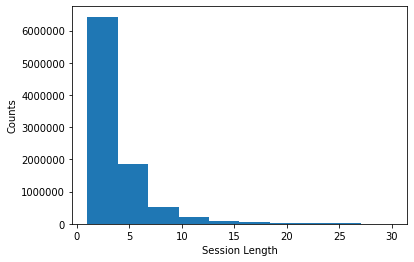

In [6]:
print(f"Total Session count: {len(X_dict.keys())}")
sess_lens = []
for k, v in X_dict.items():
    sess_lens.append(len(v))

sess_lens = np.array(sess_lens)
print(f"Min session length: {np.min(sess_lens)}")
print(f"Max session length: {np.max(sess_lens)}")

plt.hist(sess_lens)
plt.ylabel('Counts')
plt.xlabel('Session Length');
plt.show()

Generate the training data. For each session $x = [x_1,x_2,\ldots,x_m]$, apply a label $y \in [0,1]$ indicating whether a purchase was made (1) or not made (0).

In [7]:
X = []
y = []

count = 0
for k,v in X_dict.items():
    count += 1
    y_val = 0
    if k in buy_sessions:
        y_val = 1
    
    X.append(v)
    y.append(y_val)
    
    if count % 1_000_000 == 0:
        print('.', end='')

del X_dict
del buy_sessions

print()
n = 10
print(f"Top {n} samples:")
for i in range(n):
    print()
    print(X[i], y[i])

.........
Top 25 samples:

[[152, 750, 1], [152, 749, 1], [152, 751, 1], [152, 2624, 1]] 0

[[155, 5327, 1], [155, 5327, 1], [155, 9376, 1], [155, 8948, 1], [156, 8949, 1], [156, 1580, 1]] 0

[[35, 8425, 1], [35, 9040, 1], [35, 9715, 1]] 0

[[154, 10152, 1], [154, 7592, 1]] 0

[[134, 7302, 1], [135, 9401, 1]] 0

[[28, 9436, 1], [28, 9407, 1]] 0

[[126, 10438, 1], [126, 10438, 1]] 0

[[129, 2581, 1], [129, 2581, 1], [129, 2581, 1]] 0

[[56, 9319, 1], [56, 9319, 1], [56, 9346, 1], [56, 9346, 1], [56, 9346, 1], [56, 8480, 1], [56, 2264, 1], [56, 7589, 1], [56, 8538, 1], [56, 8768, 1], [56, 9437, 1], [56, 9183, 1]] 1

[[32, 8610, 1], [32, 8610, 1]] 1

[[132, 10151, 1], [132, 6250, 1], [132, 10151, 1]] 0

[[8, 2636, 1], [8, 3049, 1], [8, 2636, 1]] 0

[[129, 9451, 1], [129, 9274, 1]] 0

[[107, 6198, 1], [107, 6198, 1], [107, 6198, 1]] 0

[[18, 2244, 1], [18, 2244, 1], [18, 3982, 1], [18, 3982, 1]] 0

[[3, 2636, 1], [3, 2636, 1]] 0

[[151, 10350, 1], [151, 10350, 1], [151, 10350, 1], [151, 10

Train/test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [9]:
# Verify stratified split
buys = y_train.count(1)
abandons = y_train.count(0)
print(f"Train ratio buys to abandons: {buys / abandons}")

buys = y_test.count(1)
abandons = y_test.count(0)
print(f"Test ratio buys to abandons: {buys / abandons}")

Train ratio buys to abandons: 0.05768705861079776
Test ratio buys to abandons: 0.05768705034528095


Pickle the transformed data into files so we can load them later.

In [10]:
with open('data/X_train.pickle', "wb") as f:
    pickle.dump(X_train, f)
with open('data/y_train.pickle', "wb") as f:
    pickle.dump(y_train, f)
with open('data/X_test.pickle', "wb") as f:
    pickle.dump(X_test, f)
with open('data/y_test.pickle', "wb") as f:
    pickle.dump(y_test, f)